# **Netflix Challenge: Movie Rating Prediction with Spark**

<br>

In this tutorial, you'll build a movie rating prediction system using [Apache Spark](https://spark.apache.org/) and the [Netflix Prize dataset](https://www.kaggle.com/netflix-inc/netflix-prize-data).

You'll learn how to:

- Explore and process 100M+ data using Spark
- Encode features such as rating date and release years, and create new features from existing ones
- Train and tune predictive models (Linear Regression, Decision Trees, GBT)
- Evaluate model performance with RMSE
- Interprete and understand the model by Analyzing important features

We’ll guide you from raw Parquet files to model evaluation through a streamlined, scalable workflow.
- [Start with Feature Engineering](#FE)
- [Jump to Modeling](#ml-modelling)
- [Read the Conclusions](#conclusions)


### **Credits**

This tutorial is adapted from [100 Million Ratings with Spark on a Mac M1](https://github.com/JakobLS/100-million-rows-with-spark).


### **Compatibility and Dependencies**

| Platform                     | Compatible | Recommended | Notes                                                                                                                                                         |
| ---------------------------- | ---------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Local (e.g., M1 MacBook)** | ✅ Yes     | ❌ No       | It is not recommended to run this tutorial on a local machine due to its scale.                                                                               |
| **Google Colab**             | ❌ No      | ❌ No       | Colab CPU and memory limitations.                                                                                                                             |
| **Midway3 Login Node**       | ❌ No      | ❌ No       | It is not recommended to run this tutorial on a login node due to its scale.                                                                                  |
| **Midway3 Compute Node**     | ✅ Yes     | ✅ Yes      | Use with `sinteractive`, `scode` or [Open OnDemand](https://midway3-ondemand.rcc.uchicago.edu/) (Jupyter/VSCode). Use Java 17.0. Install PySpark and PyArrow. |



This notebook is tested to run with Python 3.12.11.
Install the required packages if you haven't done so already (If you are working in midway3, you will need to install the following packages on login node).



In [ ]:
# %pip install pyspark==3.5.6 pyarrow==20.0 kagglehub seaborn matplotlib pandas numpy

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import (
    date_format,
    datediff,
    to_date,
    udf,
    count,
    countDistinct,
)
from pyspark.sql.functions import round as spark_round
from pyspark.ml.feature import FeatureHasher, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline

In [ ]:
DATA_DIR = "../datasets/netflix-challenge"

## **Data Summary**

[The Netflix Prize dataset](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data) contains over **100 million movie ratings** from anonymous users. The data has been preprocessed into Parquet format for efficient distributed handling.

Each movie rating record contains the following information:

| Column          | Type    | Description                       |
| --------------- | ------- | --------------------------------- |
| `CustomerID`    | Integer | Anonymized user identifier        |
| `MovieID`       | Integer | Unique identifier for each movie  |
| `Rating`        | Integer | Rating given by the user (1 to 5) |
| `RatingDate`    | Date    | Date the rating was submitted     |
| `YearOfRelease` | Integer | Year the movie was released       |

#### **Feature Engineering**

We generate the following new features from existing ones to improve model performance:

| New Column           | Description                                                             |
| -------------------- | ----------------------------------------------------------------------- |
| `RatingYear`         | Year extracted from `RatingDate`                                        |
| `RatingMonth`        | Month extracted from `RatingDate`                                       |
| `Diff_RatingRelease` | Approximate number of years between rating and movie release            |
| `Diff_binned`        | Group `Diff_RatingRelease` into bins such as 1–4, 5–9, ... |
| `HashedMovieID`      | Hashed representation of `MovieID` for scalable ML input                |
| `HashedCustomerID`   | Hashed representation of `CustomerID`                                   |

Combining the original and newly created features allow us to capture **movie popularity**, **user rating behavior**, and **temporal information**, — all essential components of a real-world recommender system.


<a name="initial_eda"></a>

## [Exploratory Data Analysis](#top)
We will now take a closer look at the data by initiating a SparkContext and SparkSession. To prevent memory issues during model training on the full dataset, apply the following settings to help mitigate them.

### Memory and Garbage Collection

| Setting                                                                                        | Description                                           |
| ---------------------------------------------------------------------------------------------- | ----------------------------------------------------- |
| `spark.driver.memory = 15g`                                                                    | Allocates 15 GB RAM to the Spark driver.              |
| `spark.executor.JavaOptions = -XX:+UseG1GC`                                                    | Enables G1 Garbage Collector for executors.           |
| `spark.executor.extraJavaOptions = -XX:ConcGCThreads=20 -XX:InitiatingHeapOccupancyPercent=35` | Tunes GC thread count and early collection threshold. |

### Execution Behavior

| Setting                                            | Description                                        |
| -------------------------------------------------- | -------------------------------------------------- |
| `spark.sql.autoBroadcastJoinThreshold = -1`        | Disables automatic broadcast joins.                |
| `spark.sql.execution.arrow.pyspark.enabled = true` | Enables Arrow for faster JVM↔Python data transfer. |

<a name="data_path"></a>


In [ ]:
# Initiate SparkContext and SparkSession
try:
    conf = (
        SparkConf()
        .setMaster("local[*]")
        # JVM tuning
        .set("spark.executor.JavaOptions", "-XX:+UseG1GC")
        .set(
            "spark.executor.extraJavaOptions",
            "-XX:ConcGCThreads=20 -XX:InitiatingHeapOcuupancyPercent=35",
        )
        # Driver & shuffle
        .set("spark.driver.memory", "15g")
        .set("spark.sql.autoBroadcastJoinThreshold", "-1")  # -1 ⇒ disable broadcast
        # Arrow
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
    )

    spark = SparkSession.builder.config(conf=conf).getOrCreate()

    # Keep the console quiet
    spark.sparkContext.setLogLevel("ERROR")
except:
    print("SparkContext already running?")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 14:20:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Specify data path: change to your own path
data_path = f"{DATA_DIR}/data-parquet/part-00000-*.parquet"

# Load and display the first five rows of the data
df = spark.read.parquet(data_path)
df.show(5)

+-------+----------+------+----------+-------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|
+-------+----------+------+----------+-------------+
|   6287|   2180413|   5.0|2005-08-26|         1990|
|  11745|   1336618|   4.0|2005-08-23|         2005|
|   9458|    289514|   5.0|2005-11-29|         2005|
|   4393|   1930649|   4.0|2004-04-05|         1994|
|   7163|   2511589|   4.0|2000-11-24|         1998|
+-------+----------+------+----------+-------------+
only showing top 5 rows



In [ ]:
# How many unique customers?
df.select(countDistinct("CustomerID")).show()

+--------------------------+
|count(DISTINCT CustomerID)|
+--------------------------+
|                    376453|
+--------------------------+



In [ ]:
# How many unique movies?
df.select(countDistinct("MovieID")).show()

+-----------------------+
|count(DISTINCT MovieID)|
+-----------------------+
|                  17498|
+-----------------------+



In [ ]:
# Verify that the data types are as expected
df.printSchema()

root
 |-- MovieID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Rating: float (nullable = true)
 |-- RatingDate: date (nullable = true)
 |-- YearOfRelease: integer (nullable = true)



In [ ]:
# Display a summary of the dataset
df.summary().show(truncate=False)

+-------+-----------------+-----------------+------------------+------------------+
|summary|MovieID          |CustomerID       |Rating            |YearOfRelease     |
+-------+-----------------+-----------------+------------------+------------------+
|count  |2469758          |2469758          |2469758           |2469729           |
|mean   |9072.693858669554|1323466.822818673|3.6039093708776324|1993.9069978932912|
|stddev |5130.903339351398|764261.4968954367|1.0850219146414768|12.40376553232374 |
|min    |1                |6                |1.0               |1896              |
|25%    |4679             |662953           |3.0               |1990              |
|50%    |9051             |1320864          |4.0               |1998              |
|75%    |13636            |1984517          |4.0               |2002              |
|max    |17770            |2649429          |5.0               |2005              |
+-------+-----------------+-----------------+------------------+------------

To summarize, the data file contains:

- 17,498 unique movies
- Over 0.3 million unique customers
- over 2 million ratings
- Ratings are in the range [1-5]
- The earliest movie was released in 1896, and the most recent was in 2005
- the `YearOfRelease` column contain missing values (need to remove)
- All features have the expected data type

In [ ]:
# Drop rows with NULL values
df = df.dropna(how="any")

In [ ]:
# filter on NULL values and confirm there are no missing values
df.filter(" is NULL OR ".join(df.columns) + " is NULL").show()

NameError: name 'df' is not defined

<a name="FE"></a>

## [Feature Engineering](#top)

Knowing when the rating was given and how late it was given compared to the movie release date will help us to capture user behavior and temporal information. We will:
- create `RatingYear` and `RatingMonth` by extracting year and month from the `RatingDate`
- create `Diff_RatingRelease` by calculating the difference between `Rating Year` and the `YearOfRelease`, which is tricky and needs extra work
- convert the columns to appropriate data types using the `.cast()` method

In [ ]:
# Create new columns RatingYear, RatingMonth and Diff_RatingRelease
df = (
    df.withColumn("RatingYear", date_format(df.RatingDate, "yyyy").cast(IntegerType()))
    .withColumn("RatingMonth", date_format(df.RatingDate, "M").cast(IntegerType()))
    .withColumn(
        "Diff_RatingRelease",
        spark_round(
            datediff(df.RatingDate, to_date(df.YearOfRelease.cast("string"), "yyyy"))
            / 365.25,
            0,
        ),
    )
)

df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|
+-------+----------+------+----------+-------------+----------+-----------+------------------+
|   6287|   2180413|   5.0|2005-08-26|         1990|      2005|          8|              16.0|
|  11745|   1336618|   4.0|2005-08-23|         2005|      2005|          8|               1.0|
|   9458|    289514|   5.0|2005-11-29|         2005|      2005|         11|               1.0|
|   4393|   1930649|   4.0|2004-04-05|         1994|      2004|          4|              10.0|
|   7163|   2511589|   4.0|2000-11-24|         1998|      2000|         11|               3.0|
+-------+----------+------+----------+-------------+----------+-----------+------------------+
only showing top 5 rows



Next, we will create `Diff_binned` by grouping `Diff_ReleaseRating` into different bins. Note that here we just show an example. In real-world cases, we will experiment with different bins to find the most suitable ones for a given task.

| Values       | Bin                            |
| ------------ | ------------------------------ |
| Negative     | -1                             |
| 1 - 4.99     | 1, 2, 3, 4 and 5, respectively |
| 5 - 9.99     | 5                              |
| 10 - 49.99   | 10                             |
| 50 and above | 50                             |

<br>



In [ ]:
# define the grouping function
@udf(returnType=IntegerType(), useArrow=True)
def bin_diff(x):
    """Function for binning a value x."""
    if x is not None:
        if x < 0:
            return -1
        if x < 5:
            return x
        elif x < 10:
            return 5
        elif x < 50:
            return 10
        else:
            return 50
    else:
        return 0

In [ ]:
# Bin the Diff_RatingRelease column
df = df.withColumn("Diff_binned", bin_diff("Diff_RatingRelease").cast(IntegerType()))
df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
|   6287|   2180413|   5.0|2005-08-26|         1990|      2005|          8|              16.0|         10|
|  11745|   1336618|   4.0|2005-08-23|         2005|      2005|          8|               1.0|          1|
|   9458|    289514|   5.0|2005-11-29|         2005|      2005|         11|               1.0|          1|
|   4393|   1930649|   4.0|2004-04-05|         1994|      2004|          4|              10.0|         10|
|   7163|   2511589|   4.0|2000-11-24|         1998|      2000|         11|               3.0|          3|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
only showing top 5 rows



*If you receive error message: `java.lang.UnsupportedOperationException: sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available`, you will need to ensure that your Java version is 8 ~ 17 by running:*
```bash
module load java/17.0.10 # On Midway3
```


Moreover, we have some categorical variables that should be treated before moving forward. These are the nominal variables `MovieID` and `CustomerID`. Under current rank order representation, the `CustomerID` column will teach the estimator that, for example, the customer with `CustomerID` _1488844_ is larger/bigger/worth more than the customer with `CustomerID` _822109_. Such bias is misleading and we need to address that. There are several options we can take here, such as one-hot encoding and bin-counting, but we will go with hashing as it's more straight forward and offers computational advantages. Spark's `FeatureHasher` is well suited for this.

We leave the ordinal variables `YearOfRelease`, `RatingYear` and `RatingsMonth` as is since they are sensitive to rank order.


In [ ]:
# Create two hashers to keep the columns apart
hasherM = FeatureHasher().setInputCols(["MovieID"]).setOutputCol("HashedMovieID")
hasherC = FeatureHasher().setInputCols(["CustomerID"]).setOutputCol("HashedCustomerID")

# Apply the hashers on the dataset and display the resulting DataFrame
df = hasherM.transform(df)
df = hasherC.transform(df)
df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|       HashedMovieID|    HashedCustomerID|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|   6287|   2180413|   5.0|2005-08-26|         1990|      2005|          8|              16.0|         10|(262144,[138338],...|(262144,[211647],...|
|  11745|   1336618|   4.0|2005-08-23|         2005|      2005|          8|               1.0|          1|(262144,[138338],...|(262144,[211647],...|
|   9458|    289514|   5.0|2005-11-29|         2005|      2005|         11|               1.0|          1|(262144,[138338],...|(262144,[211647],...|
|   4393|   1930649|   4.0|2004-04-05|         1994|      2004|          4|              10.0|         10|

We will keep the target variable `Rating` as a float. This allow us to approach it as a regression rather than as a classification problem, with the advantage of providing us with the size of the error on each prediction. Besides, that was the approach in the competition.

<a name="data_vis"></a>

## [Data Visualisation](#top)

Visualize the distribution of each column. The `MovieID` and `CustomerID` columns are truncated due to their large size and only display the lowest five (which each has `count=1`) and highest 100 counts.


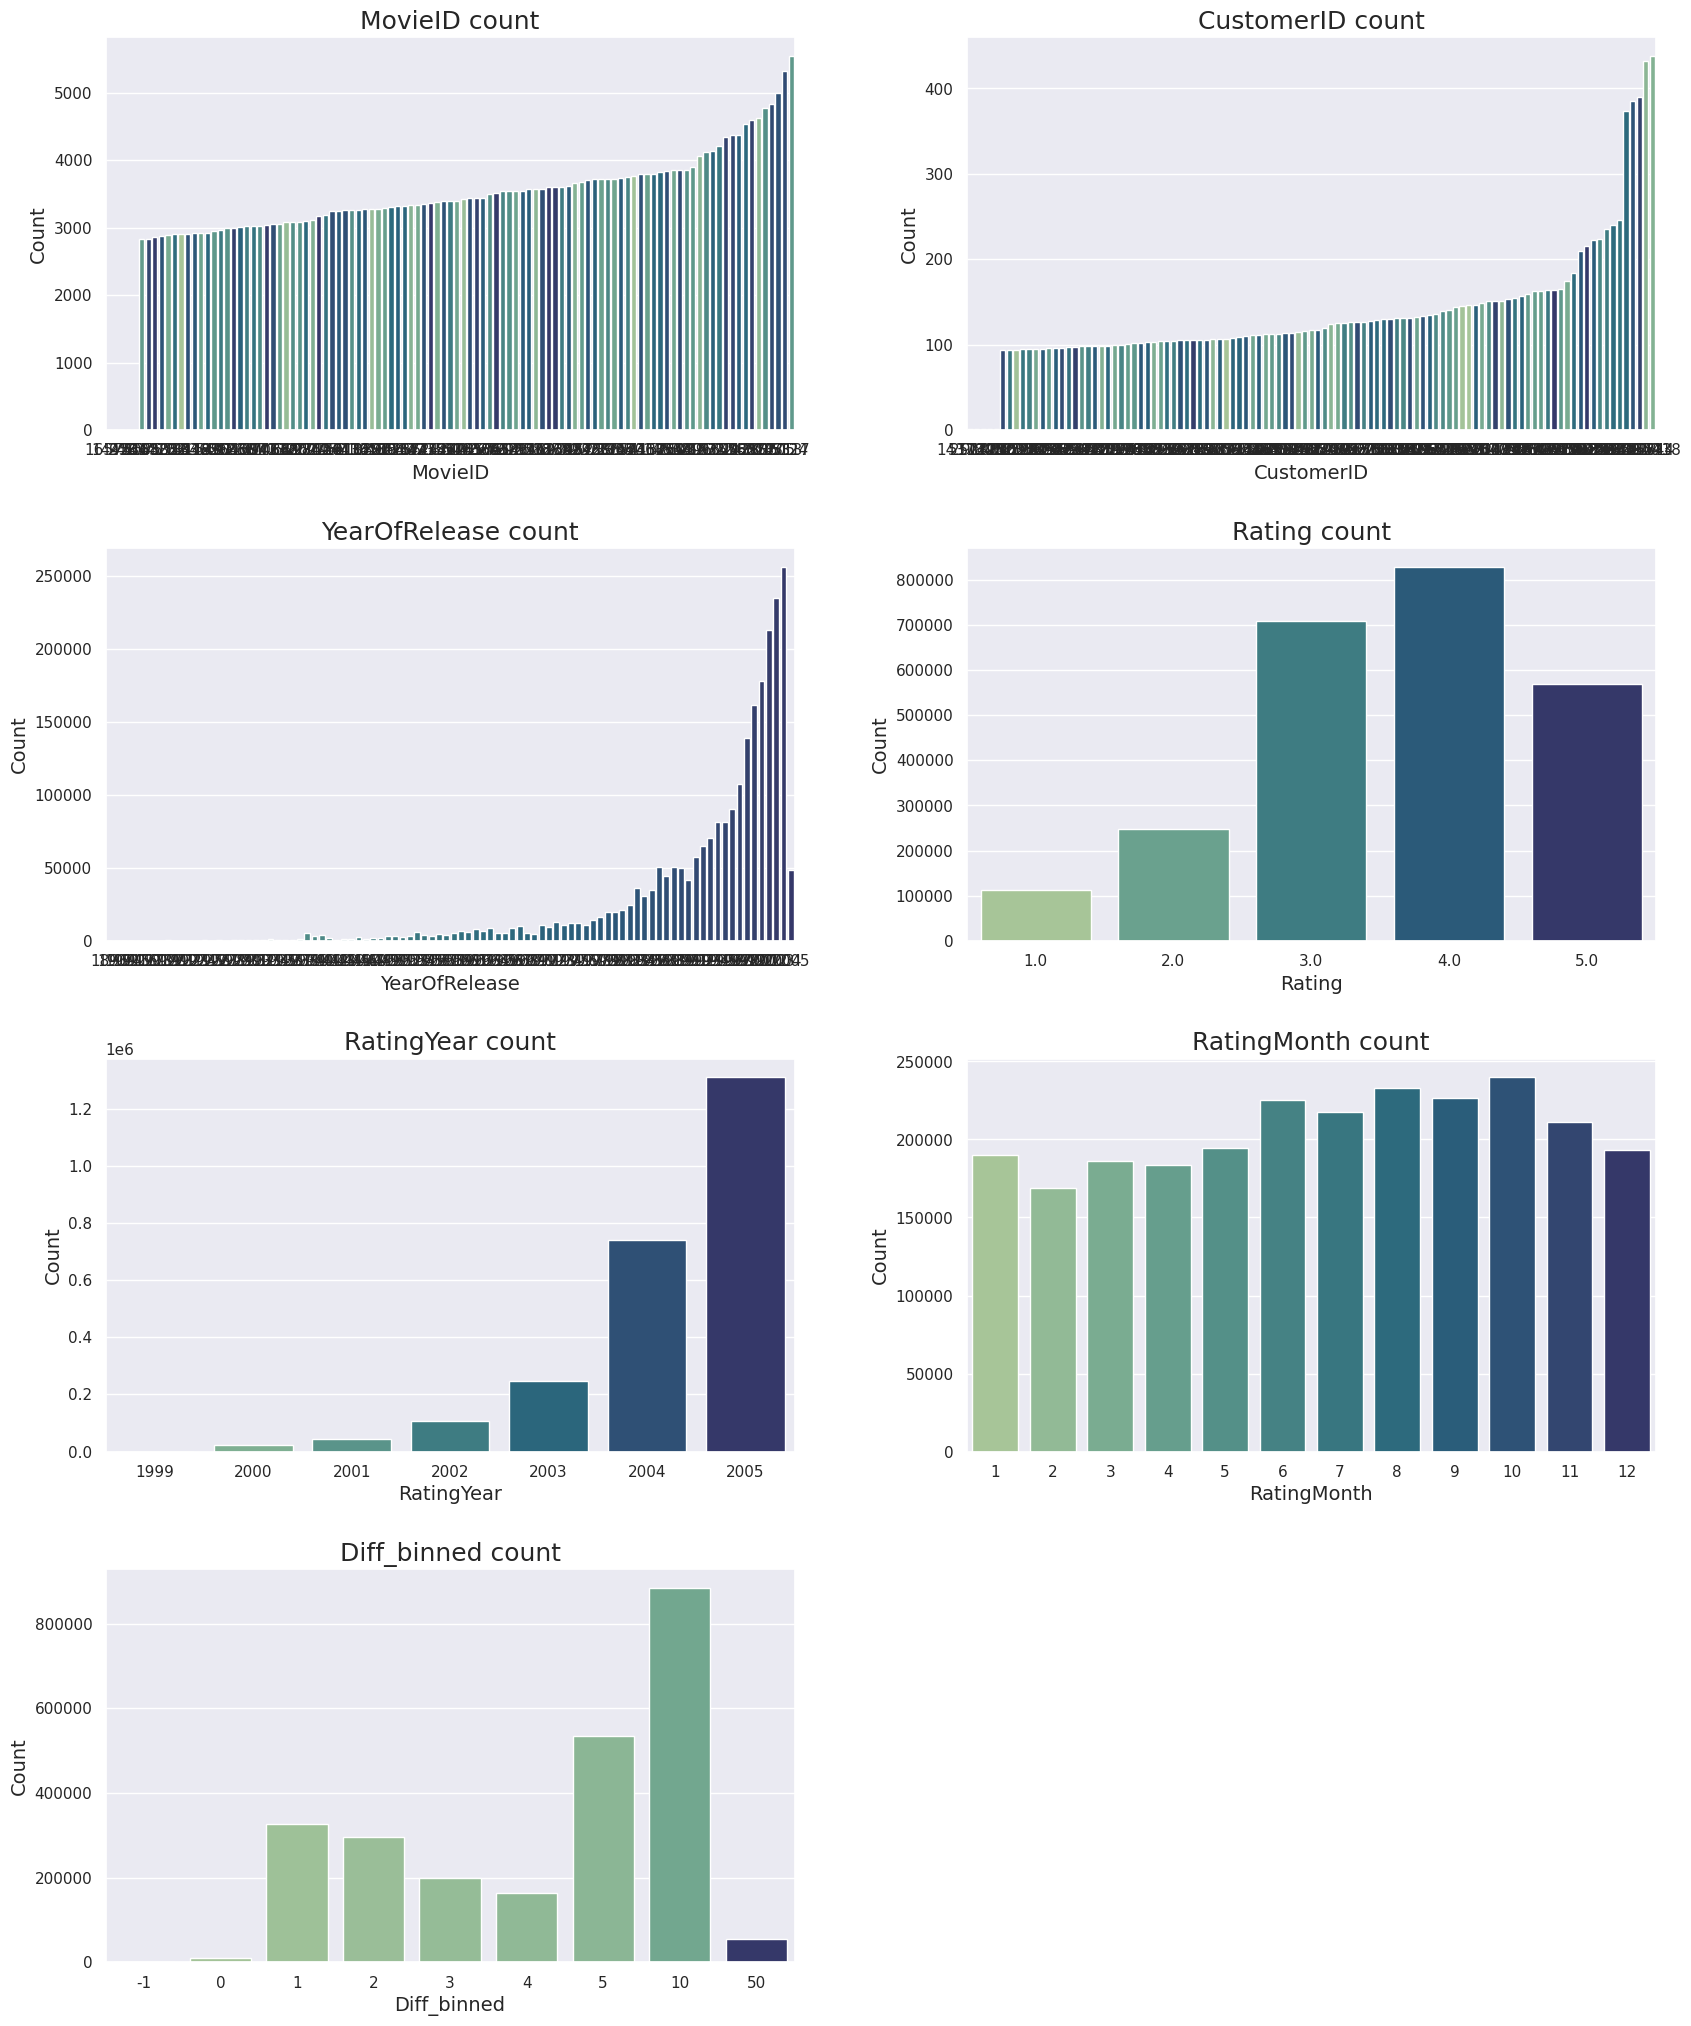

In [ ]:
# Select columns to plot
cols_for_display = [
    "MovieID",
    "CustomerID",
    "YearOfRelease",
    "Rating",
    "RatingYear",
    "RatingMonth",
    "Diff_binned",
]

plt.figure(figsize=(20, 25))
for i, col in enumerate(cols_for_display, 1):
    plt.subplot(4, 2, i)

    # Due to their large counts, prepare the ID columns different
    if col in ["CustomerID", "MovieID"]:
        counts = df.groupBy(col).count().orderBy("count").toPandas()
        cc = pd.concat([counts.head(), counts.tail(100)], ignore_index=True)

        sns.barplot(
            x=col,
            y="count",
            data=cc,
            order=cc.sort_values("count")[str(col)],
            palette="crest",
            hue=col,
            legend=False,
        )
    else:
        sns.barplot(
            x=col,
            y="count",
            data=df.groupBy(col).count().toPandas(),
            palette="crest",
            hue=col,
            legend=False,
        )

    # Specify labels, title and their size
    plt.xlabel(col, size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"{col} count", size=18)

plt.subplots_adjust(hspace=0.3, wspace=0.25)

From the above plot, we observe that:

- `MovieID` and `CustomerID` counts are highly skewed with some movies receiving many reviews and some customers giving many reviews.
- Most movies are released recently.
- Most movies received a _3_ or _4_ in rating, but there are also many *5*s. *1*s are the rarest.
- Most movies were rated in 2004 and 2005, with over 50% of the ratings in 2005.
- August, September, and October are the most popular months to rate a moive. February the least.
- Few movies are rated close to their release date (`Diff_binned` = 0). A lot of movies are rated the year after their release or within five years thereafter. _The interpretation of this last plot depends a lot on how we binned the column before. And as previously stated, binning is something that should be experimented with for best result._


<a name="ml-modelling"></a>

## [Machine Learning modelling](#top)

With a smaller dataset, we would prefer to train and test many models using cross-validation. However, with over 100 million ratings, which is fairly large, we will thus go with a more traditional train / test split:
- 80% of the data will be dedicated for training the model
- 20% for testing it
- we will set a `seed` to make sure the results are reproducible.


In [ ]:
# Split into train and test sets
splits = df.randomSplit([0.8, 0.2], seed=747)
df_train = splits[0]
df_test = splits[1]

df_train = df_train.persist()
df_test = df_test.persist()

In [ ]:
# Display the first five rows on the train set
df_train.show(5)

[Stage 52:>                                                         (0 + 1) / 1]

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|       HashedMovieID|    HashedCustomerID|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|      1|    255443|   2.0|2005-05-23|         2003|      2005|          5|               2.0|          2|(262144,[138338],...|(262144,[211647],...|
|      1|    379184|   4.0|2005-02-11|         2003|      2005|          2|               2.0|          2|(262144,[138338],...|(262144,[211647],...|
|      1|    767518|   5.0|2005-08-02|         2003|      2005|          8|               3.0|          3|(262144,[138338],...|(262144,[211647],...|
|      1|   1248029|   3.0|2004-04-22|         2003|      2004|          4|               1.0|          1|

Specify features and target variable for modelling. Model performance will be evaluated with Root Mean Squared Error (RMSE).


In [ ]:
# Specify target variable
target = StringIndexer(inputCol="Rating", outputCol="label")

# Specify features
input_cols = [
    "YearOfRelease",
    "MovieID",
    "CustomerID",
    "RatingYear",
    "RatingMonth",
    "Diff_binned",
]
featureAssembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Specify evaluator with the default RMSE as metric
evaluator = RegressionEvaluator(
    metricName="rmse", predictionCol="prediction", labelCol="label"
)

<a name="baseline"></a>

### [Get baseline results with Linear Regression and a subset](#top)

We will first apply Linear Regression as a baseline model.
Note that here we will use a subset of the data to speed up the model selection process (file `part-00000-*.parquet`, which contains 2.5 million reviews).

```python
# Specify data path: change it to your own
data_path = "data-parquet/part-00000-*.parquet"
```


In [ ]:
%%time

# Instantiate a Linear regression model with default parameters
lr = LinearRegression()

# Put everything in a Pipeline
pipeline = Pipeline(stages=[target, featureAssembler, lr])

# Train the model
baseline = pipeline.fit(df_train)

[Stage 58:>                                                         (0 + 1) / 1]

CPU times: user 18.5 ms, sys: 1.06 ms, total: 19.5 ms
Wall time: 12.3 s


For the subset data `part-00000`, the training took **7.5s on a Midway Caslake partition compute node with 8 cores and 64G memory**.


In [ ]:
def evaluate_model(model, trainSet, testSet):
    """Evaluate model performance on the train and test dataset"""

    # Evaluate model on train set
    pred_train = model.transform(trainSet)
    rmse_train = evaluator.evaluate(pred_train, {evaluator.metricName: "rmse"})

    # Evaluate model on test set
    pred_test = model.transform(testSet)
    rmse_test = evaluator.evaluate(pred_test, {evaluator.metricName: "rmse"})

    # Display results
    time.sleep(1)
    print(f"RMSE train set: {rmse_train:.5f}")
    print(f"RMSE test set:  {rmse_test:.5f}")

    return rmse_train, rmse_test

In [ ]:
# Evaluate baseline model
rmse_train, rmse_test = evaluate_model(baseline, df_train, df_test)

RMSE train set: 1.15145
RMSE test set:  1.14971


A baseline of RMSE 1.153 is achieved on the test set. The training set RMSE is 1.151, showing only a slight difference from the test dataset, indicating low variance.

> We experimented with the original `CustomerID` and `MovieID` as well as `HashedCustomerID` and `HashedMovieID`, and there's no differences in the model performance, so we will thus go with the original features

<a name="regressors"></a>

### [Compare Different Regressors on the subset](#top)

To find the best model for this task, we experimented with several other classical models: Decision Trees, Random Forest, and Gradient-Boosted Trees.

[`TrainValidationSplit`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.TrainValidationSplit.html) randomly splits the input dataset into train and validation sets, and uses evaluation metric on the validation set to select the best model. Similar to CrossValidator, but only splits the set once.


In [ ]:
%%time

# Specify regressors to evaluate
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GBTRegressor()
lr = LinearRegression()

regressors = [
    {
        "regressor": dt,
        "paramGrid": ParamGridBuilder()
        .addGrid(dt.maxBins, [16, 32])
        .addGrid(dt.maxDepth, [3, 5, 7])
        .build(),
    },
    {
        "regressor": rf,
        "paramGrid": ParamGridBuilder()
        .addGrid(rf.numTrees, [20, 40, 60])
        .addGrid(rf.maxDepth, [3, 5])
        .build(),
    },
    {
        "regressor": gb,
        "paramGrid": ParamGridBuilder()
        .addGrid(gb.subsamplingRate, [1.0, 0.7])
        .addGrid(gb.maxDepth, [3, 5])
        .build(),
    },
    {
        "regressor": lr,
        "paramGrid": ParamGridBuilder()
        .addGrid(lr.maxIter, [100, 1000])
        .addGrid(lr.regParam, [0.0, 0.01, 0.1])
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
        .build(),
    },
]

results = {}
for regressor in regressors:
    name = str(regressor["regressor"]).split("_")[0]
    print(f"\nTuning {name}")

    # Create Pipeline
    pipeline = Pipeline(stages=[target, featureAssembler, regressor["regressor"]])

    # Specify model training specs
    tvs = TrainValidationSplit(
        estimator=pipeline,
        estimatorParamMaps=regressor["paramGrid"],
        evaluator=evaluator,
        trainRatio=0.75,
        parallelism=8,
        seed=72,
    )

    # Train model
    model = tvs.fit(df_train)

    # Evaluate model
    rmse_train, rmse_test = evaluate_model(model, df_train, df_test)

    # Store the results
    results[name] = {"model": model, "rmse_train": rmse_train, "rmse_test": rmse_test}


Tuning DecisionTreeRegressor


RMSE train set: 1.14970
RMSE test set:  1.14825

Tuning RandomForestRegressor


RMSE train set: 1.15052
RMSE test set:  1.14878

Tuning GBTRegressor


RMSE train set: 1.14862
RMSE test set:  1.14716

Tuning LinearRegression


RMSE train set: 1.15145
RMSE test set:  1.14971
CPU times: user 1.62 s, sys: 317 ms, total: 1.94 s
Wall time: 15min 46s


Although with slightly differences, the Gradient-Boosted Tree Regressor (GBTRegressor) is the best model on the test data. Let's extract the best parameters and train it on the **entire dataset**.


In [ ]:
# Get the best GBTR parameters
best_gbtr = results["GBTRegressor"]["model"].bestModel
maxDepth = best_gbtr.stages[-1]._java_obj.getMaxDepth()
subSamplingsRate = best_gbtr.stages[-1]._java_obj.getSubsamplingRate()

print("maxDepth:        ", maxDepth)
print("subSamplingsRate:", subSamplingsRate)

maxDepth:         5
subSamplingsRate: 1.0


<a name="best_model"></a>

## [Train the Best GBTRegressor on the Full Dataset](#top)

Train the GBTRegressor on the entire dataset using the best parameters.

```python
# Specify data path: change to your path
data_path = "data-parquet"
```


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import FeatureHasher


@F.udf(returnType=IntegerType())
def bin_diff(x):
    """
    Bin the difference in years between rating and release.
    """
    if x is None:
        return 0
    if x < 0:
        return -1
    if x < 5:
        return int(x)
    if x < 10:
        return 5
    if x < 50:
        return 10
    return 50


def engineer_features(df):
    """
    Extract year/month from RatingDate, compute Diff_RatingRelease, and bin it.
    """
    # Convert YearOfRelease to date (Jan 1 of that year)
    release_date = F.to_date(F.col("YearOfRelease").cast("string"), "yyyy")

    df = (
        df.withColumn(
            "RatingYear", F.date_format(F.col("RatingDate"), "yyyy").cast(IntegerType())
        )
        .withColumn(
            "RatingMonth", F.date_format(F.col("RatingDate"), "M").cast(IntegerType())
        )
        .withColumn(
            "Diff_RatingRelease",
            F.round(F.datediff(F.col("RatingDate"), release_date) / 365.25, 0).cast(
                IntegerType()
            ),
        )
        .withColumn("Diff_binned", bin_diff(F.col("Diff_RatingRelease")))
    )
    return df


def hash_features(df, num_features=1024):
    """
    Apply FeatureHasher to movie and customer IDs.
    """
    hasher_movie = FeatureHasher(
        inputCols=["MovieID"], outputCol="HashedMovieID", numFeatures=num_features
    )
    hasher_cust = FeatureHasher(
        inputCols=["CustomerID"], outputCol="HashedCustomerID", numFeatures=num_features
    )

    df = hasher_movie.transform(df)
    df = hasher_cust.transform(df)
    return df


# Load entire dataset
data_path = f"{DATA_DIR}/data-parquet"
df = spark.read.parquet(data_path)
df = df.dropna(how="any")
df = engineer_features(df)
df = hash_features(df)

# Cast Rating to float for regression tasks
df = df.withColumn("Rating", F.col("Rating").cast("float"))

In [ ]:
# Split into train and test sets
splits = df.randomSplit([0.8, 0.2], seed=747)
df_train = splits[0]
df_test = splits[1]

df_train = df_train.persist()
df_test = df_test.persist()

In [ ]:
%%time

# Specify model parameters from previous step
gb_best = GBTRegressor(maxDepth=5, subsamplingRate=0.7)

# Put everything in a Pipeline
pipeline = Pipeline(stages=[target, featureAssembler, gb_best])

# Train model
final_model = pipeline.fit(df_train)

In [ ]:
# Evaluate the model
best_rmse_train_, best_rmse_test = evaluate_model(final_model, df_train, df_test)

RMSE train set: 1.14898
RMSE test set:  1.14893


We get a final score of 1.149 on the test set:
- It's slightly better than the 1.152 baseline though,
- and significantly worse than the 0.8572 the team who won the challenge in 2009 got.

Let's further explore which of the features are most important for the model to make predicitons.

<a name="feature_importance"></a>

## [Which Features are most Important?](#top)

The most important features are `YearOfRelease`, `MovieID` and `RatingMonth`, contributing 37%, 27% and 20%, . The difference between the release and rating year, `Diff_binned` contributes 3% to the overall, while `CustomerID` less than 1 percent.

This means that it matters little _who_ rated the movie and far more _which_ movie it is. This is reasonable as one would expect that most people would rate a good movie as good and rate a bad one as bad.

However, it is quite surprising that the release year matters so much. We would need to dig deeper into the data to find out why this may be the case. We won't do that here, but can speculate that, perhaps, older movies are held to newer standards, and since all ratings are from 1999 and later, while some movies are 100 years older than that, their ratings might be biased by this. Who hasn't re-watched a favourite movie from childhood and found it awful at later years? Or perhaps, newer movies might simply be better than older?


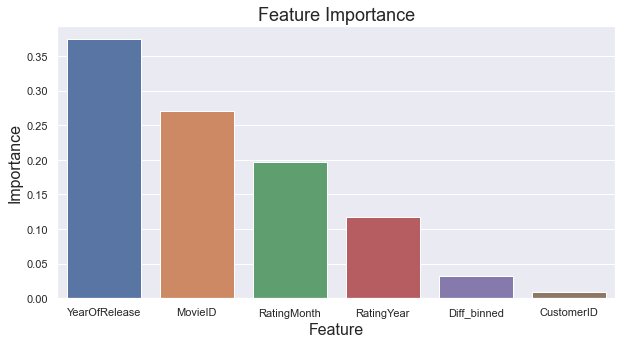

In [ ]:
# Plot and rank the features in importance
importance = pd.DataFrame(
    zip(final_model.stages[-1].featureImportances.toArray(), input_cols),
    columns=["Importance", "Feature"],
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x="Feature",
    y="Importance",
    data=importance,
    order=importance.sort_values("Importance", ascending=False)["Feature"],
)

plt.xlabel("Feature", size=16)
plt.ylabel("Importance", size=16)
plt.title("Feature Importance", size=18)

<br>

<a name="conclusions"></a>

## [Conclusions](#top)

We've trained a few models on the 100 million ratings dataset obtained from the Netflix challenge back in 2009. Although the model performance isn't as good as what was attained by the winning teams (they [reportedly](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429) spent 2,000 hours during the first year of the competition), we've been successful in training a fairly large dataset locally.

A final score of 1.149 RMSE (interpreted as 1.149 points off, on average) was achieved while identifying release year, movie ID and rating month to be the most important features when predicting a movie's rating.

We only briefly covered feature engineering - the process of creating new features from current data - but this is often an incredibly important aspect in machine learning with significant predictive benefits. Other examples of new features can be the average rating per movie or year, or count/average of ratings per day and movie, number of days since a customer's first rating, and many more. Feel free to explore on your own.